In [150]:
import re
from getpass import getpass
from time import sleep
from selenium.webdriver.common.keys import Keys
from selenium.webdriver import Chrome
from selenium.common.exceptions import NoSuchElementException

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy import stats
import matplotlib_venn as vplt

In [151]:
driver = Chrome(executable_path='/Users/amywang418/Downloads/chromedriver')
driver.get('https://twitter.com/login')

In [152]:
username = driver.find_element_by_xpath('//input[@name ="session[username_or_email]"]')
username.send_keys("secretsantagenerator01956@gmail.com")

mypass = getpass()
password = driver.find_element_by_xpath('//input[@name ="session[password]"]')
password.send_keys(mypass)
password.send_keys(Keys.RETURN)

········


In [153]:
wordsearch=input()
search_input=driver.find_element_by_xpath('//input[@aria-label="Search query"]')
search_input.send_keys(wordsearch)
search_input.send_keys(Keys.RETURN)

election


In [154]:
def tweet(card):
    username = card.find_element_by_xpath('.//span').text
    try:
        handle = card.find_element_by_xpath('.//span[contains(text(),"@")]').text
    except NoSuchElementException:
        return
    try:
        datetime1 = card.find_element_by_xpath('.//time').get_attribute('datetime')
        date = datetime1[0:10]
        time = datetime1[11:22]
    except NoSuchElementException:
        return
    comment = card.find_element_by_xpath('.//div[2]/div[2]/div[1]').text
    reply = card.find_element_by_xpath('.//div[2]/div[2]/div[2]').text
    replynum = card.find_element_by_xpath('.//div[@data-testid="reply"]').text
    retweetnum = card.find_element_by_xpath('.//div[@data-testid="retweet"]').text
    likenum = card.find_element_by_xpath('.//div[@data-testid="like"]').text
    tweet = (username, handle, date, time, comment, reply, replynum, retweetnum, likenum)
    return tweet

In [155]:
data = []
twt_ids = set()
latest = driver.execute_script("return window.pageYOffset;")
scroll= True
while (scroll and len(data) < 150):
    page_card = driver.find_elements_by_xpath('//div[@data-testid="tweet"]')
    for card in page_card[-20:]:
        twt = tweet(card)
        if twt:
            twt_ID = ''.join(twt)
            if twt_ID not in twt_ids:
                twt_ids.add(twt_ID)
                data.append(twt)
    scroll_trial = 0
    while True:
        driver.execute_script('window.scrollTo(0,document.body.scrollHeight);')
        sleep(3)
        curr=driver.execute_script("return window.pageYOffset;")
        if latest == curr:
            scroll_trial += 1
            if scroll_trial >= 5:
                driver.find_element_by_link_text('Latest').click()
                sleep(2)
                break
            else:
                sleep(5)
        else:
            latest = curr
            break;

In [156]:
print(len(data))

150


In [157]:
print(data[1])

('Kyle Griffin', '@kylegriffin1', '2020-11-08', '17:25:44.00', 'George W. Bush: "I just talked to the President-elect of the United States, Joe Biden. I extended my warm congratulations and thanked him for the patriotic message he delivered last night. I also called Kamala Harris to congratulate her on her historic election."', '', '135', '1K', '5.3K')


In [179]:
def tweets_to_data_frame(tweetArray):
    
        df = pd.DataFrame(data=[tweet[4] for tweet in tweetArray], columns=['tweets'])

        df['userhandle'] = np.array([tweet[1] for tweet in tweetArray])
        df['date'] = np.array([tweet[2] for tweet in tweetArray])
        df['time'] = np.array([tweet[3] for tweet in tweetArray])
        df['len'] = np.array([len(tweet[4]) for tweet in tweetArray])
        df['reply'] = np.array([tweet[5] for tweet in tweetArray])
        df['replies'] = np.array([tweet[6] for tweet in tweetArray])
        df['retweets'] = np.array([tweet[7] for tweet in tweetArray])
        df['likes'] = np.array([tweet[8] for tweet in tweetArray])

        return df

In [180]:
dataframeTweets = tweets_to_data_frame(data)

Text(0, 0.5, 'Frequency')

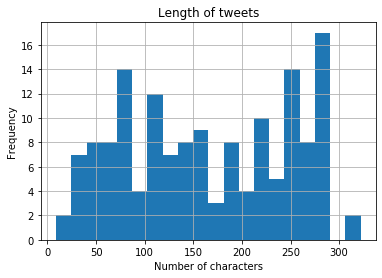

In [181]:
lengthplot = dataframeTweets['len'].hist(bins = 20)
lengthplot.set_title("Length of tweets")
lengthplot.set_xlabel("Number of characters")
lengthplot.set_ylabel("Frequency")

In [182]:
def str_to_float(x):
    if type(x) == float or type(x) == int:
        return x
    if '\n' in x:
        x = x[0: x.index('\n')]
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 1000
        return 1000.0
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000000.0
    if 'B' in x:
        return float(x.replace('B', '')) * 1000000000
    if x == '':
        return 0
    return float(x)

In [183]:
dataframeTweets['likes'] = dataframeTweets['likes'].apply(str_to_float)
dataframeTweets['retweets'] = dataframeTweets['retweets'].apply(str_to_float)
dataframeTweets['replies'] = dataframeTweets['replies'].apply(str_to_float)

In [184]:
df = pd.DataFrame({'likes':dataframeTweets['likes'], 
                   'retweets':dataframeTweets['retweets'], 
                   'replies':dataframeTweets['replies'], 
                   'length':dataframeTweets['len']})
print(df)

       likes  retweets  replies  length
0    10300.0    3400.0    654.0     112
1     5300.0    1000.0    135.0     263
2      676.0     304.0     55.0      50
3     2100.0     215.0     80.0      90
4     1300.0     436.0    609.0     153
..       ...       ...      ...     ...
145      0.0       0.0      0.0      47
146      0.0       0.0      0.0     213
147      0.0       0.0      0.0     148
148      0.0       0.0      1.0     118
149      0.0       0.0      0.0      87

[150 rows x 4 columns]


In [185]:
z_scores = stats.zscore(df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 2).all(axis=1)
new_df = df[filtered_entries]
print(new_df)

      likes  retweets  replies  length
2     676.0     304.0     55.0      50
3    2100.0     215.0     80.0      90
5    1200.0     207.0      7.0     223
6     176.0     100.0     14.0      75
7     440.0     248.0     14.0     209
..      ...       ...      ...     ...
145     0.0       0.0      0.0      47
146     0.0       0.0      0.0     213
147     0.0       0.0      0.0     148
148     0.0       0.0      1.0     118
149     0.0       0.0      0.0      87

[143 rows x 4 columns]


In [186]:
a = new_df['replies']
b = new_df['likes']
c = new_df['retweets']
d = new_df['length']
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(a,b)
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(b,c)
slope3, intercept3, r_value3, p_value3, std_err3 = stats.linregress(a,c)
slope4, intercept4, r_value4, p_value4, std_err4 = stats.linregress(d,b)

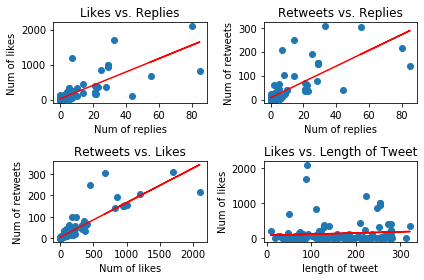

In [187]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(a, b)
axs[0, 0].plot(a, slope1*a + intercept1, c='r')
axs[0, 0].set_title("Likes vs. Replies")
axs[0, 0].set_xlabel("Num of replies")
axs[0, 0].set_ylabel("Num of likes")

axs[1, 0].scatter(b, c)
axs[1, 0].plot(b, slope2*b + intercept2, c='r')
axs[1, 0].set_title("Retweets vs. Likes")
axs[1, 0].set_xlabel("Num of likes")
axs[1, 0].set_ylabel("Num of retweets")

axs[0, 1].scatter(a, c)
axs[0, 1].plot(a, slope3*a + intercept3, c='r')
axs[0, 1].set_title("Retweets vs. Replies")
axs[0, 1].set_xlabel("Num of replies")
axs[0, 1].set_ylabel("Num of retweets")

axs[1, 1].scatter(d, b)
axs[1, 1].plot(d, slope4*d + intercept4, c='r')
axs[1, 1].set_title("Likes vs. Length of Tweet")
axs[1, 1].set_xlabel("length of tweet")
axs[1, 1].set_ylabel("Num of likes")
fig.tight_layout()

In [188]:
def calcRsqr(x, y, r):
    rsqr = r * r
    print("The r-squared value between " + x + " and " + y + " is: " + str(rsqr))
    if (rsqr > 0.5):
        print("There is a positive correlation between " + x + " and " + y + "\n")
    else:
        print("There is no correlation between " + x + " and " + y + "\n")

In [189]:
calcRsqr("num of replies", "num of likes", r_value1)
calcRsqr("num of likes", "num of retweets", r_value2)
calcRsqr("num of replies", "num of retweets", r_value3)
calcRsqr("length of tweet", "num of likes", r_value4)

The r-squared value between num of replies and num of likes is: 0.6248693858879704
There is a positive correlation between num of replies and num of likes

The r-squared value between num of likes and num of retweets is: 0.7842370622827423
There is a positive correlation between num of likes and num of retweets

The r-squared value between num of replies and num of retweets is: 0.5652682854742318
There is a positive correlation between num of replies and num of retweets

The r-squared value between length of tweet and num of likes is: 0.008469368354960895
There is no correlation between length of tweet and num of likes



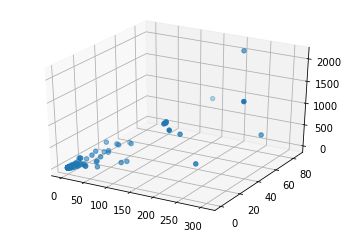

In [190]:
%matplotlib inline
fig = plt.figure()
ax = plt.axes(projection='3d')

zdata = new_df['likes']
xdata = new_df['retweets']
ydata = new_df['replies']
ax.scatter3D(xdata, ydata, zdata);

In [170]:
print(dataframeTweets['tweets'])

0      If Joe Biden really wants to unify this countr...
1      George W. Bush: "I just talked to the Presiden...
2      NEW: President George W. Bush on the 2020 elec...
3      There’s no evidence of election fraud, but the...
4      We are fighting around the clock to DEFEND the...
                             ...                        
145      Here's who really won and lost in this election
146    Enjoy weekend vibes at #Cinergy today with mov...
147    As Election Day approaches remember to #GetPol...
148    BREAKING: A HIGHLY IRREGULAR ELECTION - Federa...
149    Same shit, different election https://instagra...
Name: tweets, Length: 150, dtype: object


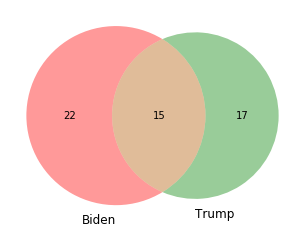

In [191]:
trump = 0
biden = 0
both = 0
t = ["Trump", "trump", "Donald", "donald", "Republican", "republican"]
b = ["Biden", "biden", "Joe", "joe", "Democrat", "democrat"]
for tweet in dataframeTweets['tweets']:
    if (any(name in tweet for name in t) and any(name in tweet for name in b)):
        both += 1
    elif (any(name in tweet for name in t)):
        trump +=1
    elif (any(name in tweet for name in b)):
        biden +=1
        
%matplotlib inline
v = vplt.venn2(subsets=(biden,trump,both), set_labels = ('Biden', 'Trump'))
plt.show()

In [192]:
bad = 0
badwords = open("badword.txt","r").read().split('\n')
for tweet in dataframeTweets['tweets']:
    if any(name in tweet for name in badwords):
        bad += 1
        print(tweet + "\n")
print(str(bad) + " tweets contain bad / curse words!")

all these bitches using Biden’s election as an excuse to post nudes as if they don’t wh0re themselves out online every other day

Rly would love for the cynicism from the most privileged people to get the hell off my timeline oh my god. You, who will arguably have the least to lose should this special election go the other way, complaining about ppl trying to muster up enthusiasm and hope and action? Gtfo.

If Trump had 1/10 of a brain he would have withheld the Barrett appointment until after the election to force the GOP to back him on this ridiculous victory claim. And it might have worked in the right courtrooms.

We are so lucky he’s as dumb as he is. The next one won’t be.

TO TRUMP'S ELECTION LAWYERS: listen up, bitches. #FRCP 
@MelissaJPeltier
 @DrDinD
 @_Jo_di
 @NYCanegirl
 @northeast_mama

One nice thing about election coverage is we no longer use shit like this

#wardamneagle
forever 
 yall made me proud, to bad the whole state didn't share the understanding but at least my 

In [193]:
users = pd.DataFrame({'userhandle':dataframeTweets['userhandle'], 
                   'tweets': 1})

In [194]:
groupbyusers = users[['userhandle', 'tweets']].groupby('userhandle').sum()

In [195]:
groupbyusers.sort_values(by = "tweets", ascending=False).head()

,tweets
userhandle,
@JoyAnnReid,5
@SabrinaSiddiqui,2
@W7VOA,2
@LALewman,2
@stvarts,2


In [196]:
badsites = open("badNews.txt","r").read().split('\n')
prominentsites = open("prominentsites.txt","r").read().split('\n')

In [197]:
urls = 0
fake = 0
prominent = 0
domains = [".com", ".net", ".org", ".news", ".co", ".gov", ".info", 
           ".edu", ".site", ".us"]
for tweet in dataframeTweets['tweets']:
     if any(dom in tweet for dom in domains):
        if any(bsite in tweet for bsite in badsites):
            print("Bad tweet ------- "+ tweet + "\n")
            fake += 1
        if any(psite in tweet for psite in prominentsites):
            print("Prominent tweet ------- "+ tweet + "\n")
            prominent += 1
        urls += 1
for reply in dataframeTweets['reply']:
     if any(dom in reply for dom in domains):
        if any(bsite in reply for bsite in badsites):
            print("Bad reply ------- "+ tweet + "\n")
            fake += 1
        if any(psite in reply for psite in prominentsites):
            print("Prominent reply ------- " + reply + "\n")
            prominent += 1
        urls += 1

Prominent tweet ------- Chris Christie, close Trump ally, says show some proof of election fraud or 'time to move on' 

"Show us. Because if you can't show us, we can't do this. We can't back you blindly without evidence."

https://nbcnews.com/politics/2020-election/chris-christie-close-trump-ally-suggests-it-may-soon-be-n1247036… via 
@nbcnews



In [198]:
print("There are a total of " + str(urls) + " urls.")
print(str(fake) + " references to bad websites.")
print(str(prominent) + " references to prominent websites.")

There are a total of 55 urls.
0 references to bad websites.
1 references to prominent websites.
